# SEMANTIC CLUSTERING OF THE LOCATIONS
# (USING THE LOG DATAFRAME)

### IMPORT LIBRARIES

In [1]:
from collections import defaultdict
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from sklearn.metrics import *
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates
import pickle
import folium
from folium import plugins
from folium.plugins import HeatMap
import selenium.webdriver
import json
from sklearn import preprocessing

plt.rcParams["font.family"] = 'serif'

#### Define the parameters to select the correct area and time period

In [37]:
stop = '5'
id_area = '2'
month =  '9'
n_months = '2'
week = '0'

month_code = month
if n_months != "1":
    for m in range(1, int(n_months)):
        month_code += "_" + str(int(month)+m)

#### Open the dataframe of the location features

In [38]:
path = '../../../datasets/out/Traj' + stop + 'min/'
file_name_in = 'loc_feat_area'+id_area+'_month'+month_code+'_week'+ week + '_compl_log_norm.csv'
file_name_out = '_area'+id_area+'_month'+month_code+'_week'+ week + '_log'

df = pd.read_csv(path+file_name_in)

print("the number of different vehicles is", len(df["vehicle"].unique()))
tot_loc = len(df["vehicle"])
print("the total number of locations is", tot_loc)

the number of different vehicles is 712
the total number of locations is 109335


In [39]:
df.describe() 

,loc_id,is_regular,loc_proto_lat,loc_proto_lon,n_next_locs,radius,entropy,support,avg_stay_weekday_day,avg_stay_weekend_day,...,k_supermarket,d_gas,d_parking,d_pier,d_hotel,d_food,d_leisure,d_shop,d_service,d_supermarket
count,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,...,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000
mean,128.405158,0.145653,0.479416,0.749837,0.143101,0.155393,0.206146,0.103023,0.274768,0.040678,...,0.314756,0.721886,0.828397,0.988166,0.914745,0.590553,0.579982,0.627643,0.568019,0.710229
std,124.630807,0.352760,0.061089,0.055686,0.139268,0.166455,0.401222,0.109636,0.281936,0.150279,...,0.232126,0.202837,0.193569,0.065418,0.174352,0.166220,0.148629,0.182431,0.138110,0.214386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,0.000000,0.449828,0.736013,0.000000,0.000000,0.000000,0.059680,0.000000,0.000000,...,0.000000,0.577277,0.657353,1.000000,1.000000,0.485429,0.486727,0.514830,0.481099,0.552760
50%,91.000000,0.000000,0.472772,0.753163,0.159099,0.135532,0.000000,0.059680,0.326170,0.000000,...,0.315465,0.662585,1.000000,1.000000,1.000000,0.590732,0.560553,0.608478,0.564278,0.655617
75%,175.000000,0.000000,0.505175,0.772169,0.252166,0.269632,0.000000,0.134867,0.516904,0.000000,...,0.500000,1.000000,1.000000,1.000000,1.000000,0.678745,0.642558,0.703375,0.643749,1.000000
max,877.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Remove the columns for the vehicle and the location id that are not relevant right now

In [40]:
df_corr = df.copy()
df_corr.drop(['vehicle', 'loc_id'], axis=1, inplace=True)

#### We plot the distribution of the variables

In [ ]:
# draw the distribution of the attributes 
fig = plt.figure(figsize=(100, 100)) 
fig_dims = (8, 9)

plot_type = ["line" for i in df_corr.keys()]
plot_type[0:2] = ["pie", "ignore", "ignore"]

#plot_type = ["pie", "ignore", "ignore", "bar", "line", "line", "line", "line", "line", "line", "line", "line", "line", 
          #  "line", "line", "line", "line", "line", "line", "line", "bar", "bar", "bar", "bar", "bar", "bar", "bar", "bar", 
           # "bar", "bar", "bar", "bar", "bar", "bar", "bar", "bar", "bar", "bar", "line", "line", "line", 
          #   "line", "line", "line", "line", "line", "line", "line", "line", "line", "line", "line", "line", "line", "line"]
plt.rcParams["font.size"] = 13

skip = 0

for i in range(len(df_corr.keys())-1):
    k = df_corr.keys()[i]
    t = plot_type[i]
    ax = plt.subplot2grid(fig_dims, (int((i-skip)/9), (i-skip)%9))
    
    if t == "pie":
        labels = 'Not Regular', 'Regular'
        sizes = df_corr[k].value_counts()
        explode = (0, 0.05)
        c = ["#97c170", "#dde37a", "#e1bd66", "#EAC435"]
        inside, texts, ltexts = ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=50, colors=c)
        for i in range(len(texts)):
            texts[i].set_fontsize(12)
            ltexts[i].set_fontsize(12)
        ax.axis('equal') 
        plt.title(k)
        
    if t == "line":
        x = range(0, len(df_corr))
        y = sorted(df_corr[k])
        plt.plot(x, y, color = '#EAC435', linewidth=2.5)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel("locations", fontsize=13)
        plt.ylabel(k, fontsize=13)
        plt.grid(True)
        plt.title(k)
    
    if t == "bar":
        x = range(0, len(df_corr))
        y = sorted(df_corr[k])
        _, bins, _ = plt.hist(df_corr[k], 20, color = '#97c170', ec='#FFFFFF')
        ax.set_xlabel(k, fontsize=13)
        ax.set_ylabel("number of locations", fontsize=13)
        plt.title(k)

    if t == "ignore":
        skip += 1
        
plt.savefig('../../../thesis/images/distribution'+file_name_out+'_minmax.png', format='png', bbox_inches='tight')
plt.close(fig)

#### Draw the correlation plot of the individual, collective and geographical features to understand if some attributes are redundant

In [ ]:
# color map from purple to orange
cmap = cm.get_cmap('PuOr')

plt.rcParams["font.size"] = '16'

# draw the heatmap first for the individual features, and then for the collective and the geographical
# the correlation between the individual and the others are almost none
# and this way we work with 2 smaller matrices

# individual heatmap
fig = plt.figure()
fig.set_size_inches(40,30)

# take only the first part of the dataset
correlati = df_corr.iloc[ : , :35].corr()
correlati = correlati.round(2)
ax = sns.heatmap(correlati, cmap=cmap, vmin = -1, vmax = 1, annot = True,linewidths=.4)

# little trick to solve the bug that the heatmap is cut 
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xticks(rotation=90)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('../../../thesis/images/corr'+file_name_out+'_indiv.png', format='png', bbox_inches='tight')
plt.close(fig)

# collective and geographical heatmap
fig = plt.figure()
fig.set_size_inches(40,30)

# take only the second and third part of the dataset
correlati = df_corr.iloc[ : , 35:].corr()
correlati = correlati.round(2)
ax = sns.heatmap(correlati, cmap=cmap, vmin = -1, vmax = 1, annot = True,linewidths=.4)

# little trick to solve the bug that the heatmap is cut 
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xticks(rotation=90)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('../../../thesis/images/corr'+file_name_out+'_coll_geo.png', format='png', bbox_inches='tight')
plt.close(fig)

#### We can remove the attributes that have a high correlation with another

In some cases we perform a mean of the correlated columns, in other cases, if the information is just redundant, we just remove the attribute

In [41]:
df_corr.drop(["support"], axis=1, inplace=True)

avg_stay_weekday = (df_corr["avg_stay_weekday_day"] + df_corr["avg_stay_weekday_night"])/2
avg_stay_weekend = (df_corr["avg_stay_weekend_day"] + df_corr["avg_stay_weekend_night"])/2
std_stay_weekday = (df_corr["std_stay_weekday_day"] + df_corr["std_stay_weekday_night"])/2
std_stay_weekend = (df_corr["std_stay_weekend_day"] + df_corr["std_stay_weekend_night"])/2

df_corr = df_corr.assign(avg_stay_weekday=avg_stay_weekday, avg_stay_weekend=avg_stay_weekend,
                         std_stay_weekday=std_stay_weekday, std_stay_weekend=std_stay_weekend)

df_corr.drop(["avg_stay_weekday_day", "avg_stay_weekday_night", "avg_stay_weekend_day", "avg_stay_weekend_night",
              "std_stay_weekday_day", "std_stay_weekday_night", "std_stay_weekend_day", "std_stay_weekend_night"], axis=1, inplace=True)


avg_time_weekday_day = (df_corr["avg_leave_weekday_day"] + df_corr["avg_arrive_weekday_day"])/2
avg_time_weekend_day = (df_corr["avg_leave_weekend_day"] + df_corr["avg_arrive_weekend_day"])/2
avg_time_weekday_night = (df_corr["avg_leave_weekday_night"] + df_corr["avg_arrive_weekday_night"])/2
avg_time_weekend_night = (df_corr["avg_leave_weekend_night"] + df_corr["avg_arrive_weekend_night"])/2

df_corr = df_corr.assign(avg_time_weekday_day=avg_time_weekday_day, avg_time_weekend_day=avg_time_weekend_day,
                         avg_time_weekday_night=avg_time_weekday_night, avg_time_weekend_night=avg_time_weekend_night)

df_corr.drop(["avg_leave_weekday_day", "avg_arrive_weekday_day", "avg_leave_weekend_day", "avg_arrive_weekend_day",
              "avg_leave_weekday_night", "avg_arrive_weekday_night", "avg_leave_weekend_night", "avg_arrive_weekend_night"], axis=1, inplace=True)

df_corr.drop(["avg_leave_mov_duration", "avg_arrive_mov_duration", "std_leave_mov_duration", "std_arrive_mov_duration"], axis=1, inplace=True)

df_corr.drop(["centrality5K", "rev_centrality3", "rev_centrality8", "rev_centrality10"], axis=1, inplace=True)

# move the collective features as the last columns of the dataframe
columns_df_c = ["exclusivity", "centrality1K", "centrality15K", "rev_centrality1", "rev_centrality5", "rev_centrality20"]
df_corr = df_corr[[c for c in df_corr if c not in columns_df_c] + [c for c in columns_df_c if c in df_corr]]

# move the geographical features as the last columns of the dataframe
categories = ["gas", "parking", "pier", "hotel", "food", "leisure", "shop", "service", "supermarket"]
columns_df_g = ["n_"+c for c in categories]+["k_"+c for c in categories]+["d_"+c for c in categories]
df_corr = df_corr[[c for c in df_corr if c not in columns_df_g] + [c for c in columns_df_g if c in df_corr]]

In [7]:
df_corr.describe()

,is_regular,loc_proto_lat,loc_proto_lon,n_next_locs,radius,entropy,n_stop_weekday_day,n_stop_weekend_day,n_stop_weekday_night,n_stop_weekend_night,...,k_supermarket,d_gas,d_parking,d_pier,d_hotel,d_food,d_leisure,d_shop,d_service,d_supermarket
count,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,...,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000,109335.000000
mean,0.145653,0.479416,0.749837,0.143101,0.155393,0.206146,0.168918,0.022187,0.033162,0.012375,...,0.314756,0.721886,0.828397,0.988166,0.914745,0.590553,0.579982,0.627643,0.568019,0.710229
std,0.352760,0.061089,0.055686,0.139268,0.166455,0.401222,0.116975,0.071661,0.092715,0.059135,...,0.232126,0.202837,0.193569,0.065418,0.174352,0.166220,0.148629,0.182431,0.138110,0.214386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.449828,0.736013,0.000000,0.000000,0.000000,0.099708,0.000000,0.000000,0.000000,...,0.000000,0.577277,0.657353,1.000000,1.000000,0.485429,0.486727,0.514830,0.481099,0.552760
50%,0.000000,0.472772,0.753163,0.159099,0.135532,0.000000,0.158033,0.000000,0.000000,0.000000,...,0.315465,0.662585,1.000000,1.000000,1.000000,0.590732,0.560553,0.608478,0.564278,0.655617
75%,0.000000,0.505175,0.772169,0.252166,0.269632,0.000000,0.231515,0.000000,0.000000,0.000000,...,0.500000,1.000000,1.000000,1.000000,1.000000,0.678745,0.642558,0.703375,0.643749,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### We can compute the correlation matrix again after the varible transformation (in this case we draw only one heatmap)

In [ ]:
# correlation matrix only with the collective and geographic features

cmap = cm.get_cmap('PuOr')

fig = plt.figure()
fig.set_size_inches(60, 50)

correlati = df_corr.corr()
correlati = correlati.round(2)
ax = sns.heatmap(correlati, cmap=cmap, vmin = -1, vmax = 1, annot = True,linewidths=.4)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xticks(rotation=90)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig('../../../thesis/images/corr'+file_name_out+'_after.png', format='png', bbox_inches='tight')
plt.close(fig)

## K-MEANS CLUSTERING OF THE FEATURES

#### Compute the sse and the silhouette for k in the range from 2 to 1000

In [ ]:
############################ DO NOT RUN AGAIN, TOO LONG ############################
sse_list = list()
# sil_list = list()
print("range 2-10, step 2") #4run
for k in range(2, 10, 2):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_corr)
    sse = kmeans.inertia_
    sse_list.append(sse)
#     sil = silhouette_score(df_corr, kmeans.labels_)
#     sil_list.append(sil)

with open(path+"sse"+file_name_out+'.pickle', 'wb') as fp:
    pickle.dump(sse_list, fp)
#     pickle.dump(sil_list, fp)
    
print("range 10-50, step 5") #8run
for k in range(10, 50, 5):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_corr)
    sse = kmeans.inertia_
    sse_list.append(sse)
#     sil = silhouette_score(df_corr, kmeans.labels_)
#     sil_list.append(sil)

with open(path+"sse"+file_name_out+'.pickle', 'ab') as fp:
    pickle.dump(sse_list, fp)
#     pickle.dump(sil_list, fp)

print("range 50-200, step 15") #10run
for k in range(50, 200, 15):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_corr)
    sse = kmeans.inertia_
    sse_list.append(sse)
#     sil = silhouette_score(df_corr, kmeans.labels_)
#     sil_list.append(sil)

with open(path+"sse"+file_name_out+'.pickle', 'ab') as fp:
    pickle.dump(sse_list, fp)
#     pickle.dump(sil_list, fp)
    
print("range 200-1000, step 100") #4run
for k in range(200, 1000, 100):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_corr)
    sse = kmeans.inertia_
    sse_list.append(sse)
#     sil = silhouette_score(df_corr, kmeans.labels_)
#     sil_list.append(sil)
    
with open(path+"sse"+file_name_out+'.pickle', 'ab') as fp:
    pickle.dump(sse_list, fp)
#     pickle.dump(sil_list, fp)

#### Read the pickle files containing the sse and silhouette values

In [ ]:
with open(path+"sse"+file_name_out+'.pickle', 'rb') as fp:
    sse_list1 = pickle.load(fp)
#     sil_list1 = pickle.load(fp)
    
    sse_list2 = pickle.load(fp)
#     sil_list2 = pickle.load(fp)

    sse_list3 = pickle.load(fp)
#     sil_list2 = pickle.load(fp)

    sse_list = pickle.load(fp)
#     sil_list = pickle.load(fp)  

#### Draw the sse and the silhouette values obtained

In [ ]:
# draw sse
fig = plt.figure()
fig.set_size_inches(6,3)
plt.rcParams["font.size"] = '16'
x = list(range(2, 10, 2)) + list(range(10, 50, 5)) + list(range(50, 200, 15)) + list(range(200, 1000, 100))

# plt.plot(x, sse_list, color = '#0c2c84', linewidth=4)## area 11
# plt.plot(140, sse_list[18], "o", color = '#0c2c84', markersize = 10) ## area 11
plt.plot(x, sse_list, color = '#A8201A', linewidth=4) ## area 2
plt.plot(155, sse_list[19], "o", color = '#A8201A', markersize = 10) ## area 2

# plt.yticks(np.arange(20000, 61000, 20000), ["20k", "40k", "60k"]) ## area 11
plt.yticks(np.arange(100000, 210000, 50000), ["100k", "150k", "200k"]) ## area 2
plt.xlabel("number of clusters (k)", fontsize=19)
plt.ylabel("sse", fontsize=19)
plt.title("Inter-regional Area")## area 2
# plt.title("Urban Area") ## area 11

plt.grid(True)

plt.savefig('../../../thesis/images/sse'+file_name_out+'.png', format='png', bbox_inches='tight')
plt.close(fig)

In [ ]:
# # draw silhouette
# fig = plt.figure()
# fig.set_size_inches(20,12)
# plt.rcParams["font.size"] = '16'
# x = list(range(2,10)) + list(range(10, 200, 5)) + list(range(200, 1000, 100))

# plt.plot(x, sil_list, color = '#143642', linewidth=2.5)
# # plt.plot(140, sil_list[34], "o", color = '#143642', markersize = 10) ## area 11
# plt.plot(155, sil_list[37], "o", color = '#143642', markersize = 10) ## area 2

# # plt.xticks(np.arange(0, 1000, 50)) ## area 11
# # plt.yticks(np.arange(0.06, 0.24, 0.01)) ## area 11
# plt.xticks(np.arange(0, 1000, 50)) ## area 2
# plt.yticks(np.arange(0.06, 0.22, 0.01)) ## area 2

# plt.xlabel("k", fontsize=19)
# plt.ylabel("silhouette", fontsize=19)
# plt.grid(True)

# plt.savefig('../../../thesis/images/sil'+file_name_out+'.png', format='png', bbox_inches='tight')
# plt.close(fig)

#### Choose the best k for the kmeans clustering

In [8]:
#k_best = 140 ## area 11
k_best = 155 ## area 2

#### run again the kmeans with the k chosen to compute the centroids and the dict from cluster to number of locations

In [9]:
############################ DO NOT RUN AGAIN, TOO LONG ############################
kmeans = KMeans(init='k-means++', n_clusters=k_best, n_init=10, max_iter=300, random_state = 123)
kmeans.fit(df_corr)

# get the centroids
centroids_kmeans = kmeans.cluster_centers_
labels_kmeans = kmeans.labels_

with open(path+"centroids_kmeans"+file_name_out+'.pickle', 'wb') as fp:
    pickle.dump(centroids_kmeans, fp)
    pickle.dump(labels_kmeans, fp)

In [ ]:
# area 11
print("sse", kmeans.inertia_)
print("sil", silhouette_score(df_corr, kmeans.labels_))

In [ ]:
# area 2
print("sse", kmeans.inertia_)
print("sil", silhouette_score(df_corr, kmeans.labels_))

In [10]:
with open(path+"centroids_kmeans"+file_name_out+'.pickle', 'rb') as fp:
    centroids_kmeans = pickle.load(fp)
    labels_kmeans = pickle.load(fp)
    
hist, bins = np.histogram(labels_kmeans, bins=range(0, len(set(labels_kmeans)) + 1))
# dict from cluster id to number of locs in cluster
kmeans_cluster_size = dict(zip(bins, hist)) 

## COMPUTE THE HIERARCHICAL CLUSTERING ON THE CENTROIDS

In [11]:
def compute_linkage_matrix(centroids_kmeans):
    # distance matrix
    dist_matrix = pdist(centroids_kmeans, metric='euclidean')
    # linkage matrix
    link_matrix = linkage(dist_matrix, method='ward', metric='euclidean')
    return link_matrix

#### Create a dict from cluster labels to the points in that cluster

In [12]:
def points_labels_to_clusters(points, labels):
    clusters = defaultdict(list)
    for i in range(0, len(points)):
        clusters[labels[i]].append(points[i])
    return clusters

#### Compute a set of dictionaries useful for computing measures

In [13]:
def clusters_dict(link_matrix, centroids_kmeans, labels_kmeans, kmeans_cluster_size):
    # list of linkage cluster id 
    linkage_labels = fcluster(link_matrix, cut_dist, 'distance') 
    # dict from cluster label to the points in it
    linkage_clusters = points_labels_to_clusters(np.array(centroids_kmeans), linkage_labels)

    # dict from linkage cluster id to number of locations
    link_cluster_to_n_location = dict.fromkeys(np.unique(linkage_labels), 0)
    # dict from linkage cluster id to number of kmeans clusters
    link_cluster_to_n_kcluster = dict.fromkeys(np.unique(linkage_labels), 0)
    # dict from kmeans cluster id to linkage cluster id
    kcluster_to_link_cluster = dict.fromkeys(np.unique(labels_kmeans), 0)
    for i, c in enumerate(linkage_labels):
        link_cluster_to_n_location[c] += kmeans_cluster_size[i]
        link_cluster_to_n_kcluster[c] += 1
        kcluster_to_link_cluster[i] = c
        
    return linkage_labels, link_cluster_to_n_location, link_cluster_to_n_kcluster, kcluster_to_link_cluster

#### Define a function to draw the dendrogram of the hierarchical clustering

In [14]:
def draw_dendro(cluster_id, link_matrix, cut_dist, link_cluster_to_n_location, colors, partial_cluster):
    # draw the dendrogram of the linkage clustering
    fig = plt.figure(figsize=(11, 4)) 
    
    mpl.rcParams['lines.linewidth'] = 2
    plt.rcParams["font.size"] = 16
    
    hierarchy.set_link_color_palette(colors)

    res = dendrogram(link_matrix, color_threshold = cut_dist, above_threshold_color = 'grey', no_labels= True)
    plt.axhline(y=cut_dist, c='r')
    y_ticks_max = round(link_matrix[-1][2])
    plt.yticks(np.arange(0, y_ticks_max+1, y_ticks_max/5), fontsize=18)
    plt.xlabel("K-Means centroids", fontsize=18)
    plt.ylabel("cluster distance", fontsize=18)

    legend_handles = []
    for i in range(len(partial_cluster)):
        p = int(round((link_cluster_to_n_location[i+1] * 100) /tot_loc))
        legend_handles.append(mpatches.Patch(color=colors[i], label=f"$C_{i+1} ({p}\%)$"))

    legend = plt.legend(handles=legend_handles, loc=1, ncol=2)
    
#     plt.title("Inter-regional Area") ## area 2
    plt.title("Urban Area") ## area 11

    plt.savefig('../../../thesis/images/dentro_'+id_area+'_cluster_'+str(cluster_id+2)+'.png', format='png', bbox_inches='tight')
    plt.close(fig)

#### Create a dataframe containing the kmeans centroids and linkage clustering

In [15]:
def create_df_centroids(centroids_kmeans, kcluster_to_link_cluster):
    # create a dataframe containing the kmeans centroids
    df_centroids = pd.DataFrame(centroids_kmeans, columns=df_corr.columns)
    # add a column containing for each centroids the linkage cluster id
    df_centroids["link_cluster"] = kcluster_to_link_cluster.values()

    # for each linkage cluster extract all the centroids and compute a mean
    link_centroids = []
    link_centroids_std = []
    for i in range(1, len(link_cluster_to_n_kcluster)+1):
        df_i = df_centroids[df_centroids["link_cluster"] == i]
        link_centroids.append(list(df_i.mean(axis = 0)))
        link_centroids_std.append(list(df_i.std(axis = 0)))
        
    # create a dataframe containing of each linkage cluster the mean of the centroids in it
    df_par = pd.DataFrame(link_centroids, columns=df_centroids.columns)
    
    return df_centroids, df_par, link_centroids_std

#### Draw the parallel coordinates of the cluster obtained

In [16]:
# ################# USING PANDAS LIBRARY ################ OLD VERSION
# def draw_par_coords(df_par, link_cluster_to_n_location, cluster_id):
#     # draw the parallel coordinates of the linkage clusters
#     fig = plt.figure(figsize=(35, 12)) 

#     cmap = cm.gist_rainbow(np.linspace(0.1, 1, 7))

#     parallel_coordinates(df_par, 'link_cluster', color = cmap, linewidth=3, axvlines=True, \
#                          axvlines_kwds={"linewidth":0.5, "color":"k"} )
#     plt.xticks(rotation=90, fontsize=16)
#     plt.yticks(np.arange(0, 1.01, 0.1), fontsize=16)

#     legend_handles = []
#     for i in range(1, len(link_cluster_to_n_location)+1):
#         legend_handles.append(mpatches.Patch(color=cmap[(i-1)%7], label='C'+str(i)+', n_locs ='+str(link_cluster_to_n_location[i])))

#     plt.legend(handles=legend_handles, loc=1)
    
#     plt.grid(False)

#     plt.savefig('../../../thesis/images/parallel_coord_'+id_area+'_cluster_'+str(cluster_id+2)+'.png', format='png', bbox_inches='tight')
#     plt.close(fig)

In [17]:
# ############### USING ERRORBAR
# def draw_par_coords_error(df_par, link_centroids_std, link_cluster_to_n_location, cluster_id):
    
#     # draw the parallel coordinates of the linkage clusters
#     fig, ax = plt.subplots(1,1, figsize=(35, 12)) 
#     #fig = plt.figure() 
#     cmap = cm.gist_rainbow(np.linspace(0.1, 1, 7))
#     l = len(df_par.keys()[:-1])
        
#     for i, row in df_par.iterrows():
        
#         x = [x + y for x, y in zip(range(l), np.ones(l)*0.05*i)] #df_par.keys()[:-1]
#         y = row[:-1]
#         yerr = link_centroids_std[i][:-1]
        
#         (_, caps, _) = plt.errorbar(x, y, yerr=yerr, color=cmap[i], linewidth=5, barsabove=True, \
#                             elinewidth=2, uplims=True, lolims=True, label='uplims=True, lolims=True')

#         for cap in caps:
#             cap.set_marker("_")
#             cap.set_markersize(10)
#             cap.set_markeredgewidth(3)
        
#     x_ticks_labels = df_par.keys()[:-1]
#     ax.set_xticks(x) # Set number of ticks for x-axis
#     ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16) # Set ticks labels for x-axis
#     plt.yticks(np.arange(-0.2, 1.3, 0.1), fontsize=16)

#     legend_handles = []
#     for i in range(1, len(link_cluster_to_n_location)+1):
#         legend_handles.append('C'+str(i)+', n_locs ='+str(link_cluster_to_n_location[i]))

#     plt.legend(legend_handles, loc=1)

#     plt.savefig('../../../thesis/images/parallel_coord_'+id_area+'_cluster_'+str(cluster_id+2)+'_error.png', format='png', bbox_inches='tight')
#     plt.close(fig)

In [18]:
def remove_feat(df_par):
    df_small_par = df_par.drop(['std_leave_mov_length', 'std_arrive_mov_length', 'std_stay_weekday', 'std_stay_weekend', 
                                    'centrality1K', 'rev_centrality1', 'rev_centrality5', 'n_pier', 'k_pier', 'd_pier',
                                    'avg_leave_mov_length',
                                   ], axis=1, inplace=False)

    n_stop_weekday = (df_small_par["n_stop_weekday_day"] + df_small_par["n_stop_weekday_night"])/2
    n_stop_weekend = (df_small_par["n_stop_weekend_day"] + df_small_par["n_stop_weekend_night"])/2

    avg_time_weekday = (df_small_par["avg_time_weekday_day"] + df_small_par["avg_time_weekday_night"])/2
    avg_time_weekend = (df_small_par["avg_time_weekend_day"] + df_small_par["avg_time_weekend_night"])/2

    df_small_par = df_small_par.assign(n_stop_weekday=n_stop_weekday, n_stop_weekend=n_stop_weekend, 
                                       avg_arrival_weekday=avg_time_weekday, avg_arrival_weekend=avg_time_weekend)

    df_small_par.drop(["n_stop_weekday_day", "n_stop_weekday_night", "n_stop_weekend_day", "n_stop_weekend_night",
                      "avg_time_weekday_day", "avg_time_weekday_night", "avg_time_weekend_day", "avg_time_weekend_night"], axis=1, inplace=True)

#     print(len(df_par.keys()))
#     print(len(df_small_par.keys()))

    # move the collective features as the last columns of the dataframe
    columns_df_c = ["exclusivity", "centrality15K", "rev_centrality20"]
    df_small_par = df_small_par[[c for c in df_small_par if c not in columns_df_c] + [c for c in columns_df_c if c in df_small_par]]

    # move the geographical features as the last columns of the dataframe
    categories = ["gas", "parking", "hotel", "food", "leisure", "shop", "service", "supermarket"]
    columns_df_g = ["n_"+c for c in categories]+["k_"+c for c in categories]+["d_"+c for c in categories]
    df_small_par = df_small_par[[c for c in df_small_par if c not in columns_df_g] + [c for c in columns_df_g if c in df_small_par]]

    # move linkage column to the end
    df_small_par = df_small_par[[c for c in df_small_par if c not in ["link_cluster"]] + [c for c in ["link_cluster"] if c in df_small_par]]

    return df_small_par

In [19]:
# ################# USING PANDAS LIBRARY ################ NEW VERSION
# def draw_par_coords(df_par, link_cluster_to_n_location, cluster_id, colors, linestyle):
#     # draw the parallel coordinates of the linkage clusters
#     fig = plt.figure(figsize=(20, 10)) 

#     cmap = cm.gist_rainbow(np.linspace(0.1, 1, 7))

#     parallel_coordinates(df_par, 'link_cluster', color = cmap, linewidth=3, linestyle=linestyle, axvlines=True, \
#                          axvlines_kwds={"linewidth":0.1, "color":"k"} )
#     plt.xticks(rotation=90, fontsize=16)
#     plt.yticks(np.arange(0, 1.01, 0.1), fontsize=16)

#     legend_handles = []
#     for i in range(1, len(link_cluster_to_n_location)+1):
#         legend_handles.append(mpatches.Patch(color=cmap[(i-1)%7], label='C'+str(i)+', n_locs ='+str(link_cluster_to_n_location[i])))

#     plt.legend(handles=legend_handles, loc=1)
    
#     plt.grid(False)
    
#     plt.text(3, -0.01, 'Individual Features')
#     plt.text(0, -0.03, '----------------------------------------------------------------')
#     plt.text(11.5, -0.01, 'Collective Features')
#     plt.text(13, -0.03, '----------')
#     plt.text(26, -0.01, 'Geographic Features')
#     plt.text(16, -0.03, '-----------------------------------------------------------------------------------------------------------------------')

#     plt.text(15.8, -0.37, '(number of POIs in \na radius of 500 meters)')
#     plt.text(23.6, -0.37, '(number of POIs between \nthe 30 nearest neighbors)')
#     plt.text(33, -0.37, '(distance of the \nclosest POI)')

#     plt.savefig('../../../thesis/images/parallel_coord_'+id_area+'_cluster_'+str(cluster_id+2)+'.png', format='png', bbox_inches='tight')
#     plt.close(fig)

In [20]:
################# USING PANDAS LIBRARY ################ NEWEST VERSION
def draw_par_coords(df_total, lines_to_draw, colors_parall, parall_linestyle, cluster_id):
        
    # draw the parallel coordinates of the linkage clusters
    fig, ax = plt.subplots(1,1, figsize=(16, 6)) 
    #fig = plt.figure(figsize=(16, 8)) 
    x = df_total.keys()[:-3] #[x + y for x, y in zip(range(l), np.ones(l)*0.05*i)]
    
    y=[]
        
    for i, c in enumerate(lines_to_draw):
        
        row = df_total[df_total["partial_cluster"] == c].iloc[0]        
        y.append(np.array(row[:-3], dtype=float))     
        ax.plot(x, y[i], color=colors_parall[i], linewidth=4, linestyle=parall_linestyle[i])
        
    plt.xticks(rotation='vertical', fontsize=16)
    plt.yticks(np.arange(0, 1.05, 0.2), fontsize=22)
    
    ax.fill_between(x, y[0], y[1], facecolor='#f2f2f2')

    legend_handles = []
    for i, c in enumerate(lines_to_draw):
        row = df_total[df_total["partial_cluster"] == c].iloc[0]
        n_locs = row.loc["partial_cluster_size"]
        p = int(round((n_locs * 100) /tot_loc))
        legend_handles.append(mpatches.Patch(color=colors_parall[i], label=f"$C_{i+1} ({p}\%)$"))
    
    plt.legend(handles=legend_handles, loc=4, ncol=2)
    
    plt.axvline(x=12.5, c='#333333')
    plt.axvline(x=15.5, c='#333333')

    plt.text(0, 0.88, 'Indiv',fontsize=25)
    plt.text(12.8, 0.88, 'Coll',fontsize=25)
    plt.text(15.8, 0.88, 'Cont',fontsize=25)

    plt.text(15.8, -0.6, '(number of POIs in \na radius of 500 \nmeters)')
    plt.text(23.6, -0.6, '(number of POIs \nbetween the 30 \nnearest neighbors)')
    plt.text(32, -0.6, '(distance of the \nclosest POI)')
    
    plt.title("Inter-regional Area",fontsize=28)## area 2
    #plt.title("Urban Area",fontsize=28) ## area 11

    plt.savefig('../../../thesis/images/parallel_coord_'+str(id_area)+'_cluster_'+str(cluster_id+2)+'.png', format='png', bbox_inches='tight')
    plt.close(fig)

#### Compute the clusters splitting recursively according to the dendrogram

In [21]:
########### AREA 2
link_matrix = compute_linkage_matrix(centroids_kmeans)

colors = [["#b15928", "#b2df8a"], ["#b15928", "#33a02c", "#a6cee3"], ["#b15928", "#33a02c", "#1f78b4", "#e7298a"],
         ["#525252", "#ff7f00", "#33a02c", "#1f78b4", "#e7298a"], 
         ["#525252", "#ffff33", "#e31a1c", "#33a02c", "#1f78b4", "#e7298a"]]

colors_parall = [["#b15928", "#b2df8a"], ["#525252", "#ff7f00"], ["#ffff33", "#e31a1c"],
                 ["#33a02c", "#a6cee3"], ["#1f78b4", "#e7298a"]]

parall_linestyle = [["-", "-"], ["-", "-"], ["-", "-"], ["-", "-"], ["-", "-"]]

partial_cluster = [["1_3", "4_6"], ["1_3", "4", "5_6"], ["1_3", "4", "5", "6"], ["1", "2_3", "4", "5", ""], 
                   ["1", "2", "3", "4", "5", "6"]]

lines_to_draw = [["1_3", "4_6"], ["1", "2_3"], ["2", "3"], ["4", "5_6"],  ["5", "6"]]

partial_cluster_size = []

In [ ]:
########### AREA 11
link_matrix = compute_linkage_matrix(centroids_kmeans)

colors = [["#b15928", "#b2df8a"], ["#b15928", "#33a02c", "#a6cee3"], ["#525252", "#ff7f00", "#33a02c", "#a6cee3"],
         ["#525252", "#ffff33", "#e31a1c", "#33a02c", "#a6cee3"], 
         ["#525252", "#ffff33", "#e31a1c", "#33a02c", "#1f78b4", "#e7298a"]]

colors_parall = [["#b15928", "#b2df8a"], ["#525252", "#ff7f00"], ["#ffff33", "#e31a1c"],
                 ["#33a02c", "#a6cee3"], ["#1f78b4", "#e7298a"]]

parall_linestyle = [["-", "-"], ["-", "-"], ["-", "-"], ["-", "-"], ["-", "-"]]

partial_cluster = [["1_3", "4_6"], ["1_3", "4", "5_6"], ["1", "2_3", "4", "5_6"], ["1", "2", "3", "4", "5_6"], 
                   ["1", "2", "3", "4", "5", "6"]]

lines_to_draw = [["1_3", "4_6"], ["1", "2_3"], ["2", "3"], ["4", "5_6"],  ["5", "6"]]

partial_cluster_size = []

In [22]:
mpl.rcParams["legend.framealpha"] = 0.95
mpl.rcParams["legend.facecolor"] = 'white' 
mpl.rcParams["legend.edgecolor"] = 'white'

first = True

for i in range(5):
    cut_dist = link_matrix[-i-1][2] - 0.01
    
    linkage_labels, link_cluster_to_n_location, link_cluster_to_n_kcluster, kcluster_to_link_cluster = clusters_dict(
                        link_matrix, centroids_kmeans, labels_kmeans, kmeans_cluster_size)
        
    draw_dendro(i, link_matrix, cut_dist, link_cluster_to_n_location, colors[i], partial_cluster[i])    
    #print(silhouette_score(centroids_kmeans, linkage_labels))
    
    df_centroids, df_par, link_centroids_std = create_df_centroids(centroids_kmeans, kcluster_to_link_cluster)
    
    df_small_par = remove_feat(df_par)
    
    if first:
        df_total = df_small_par.copy()
        first = False
    else:
        df_total = df_total.append(df_small_par)
    partial_cluster_size.extend(link_cluster_to_n_location.values())
         
df_total["partial_cluster"] = [label for sublist in partial_cluster for label in sublist] # flaten the list of list
df_total["partial_cluster_size"] = partial_cluster_size

for i in range(5):          
    #draw_par_coords_error(df_par, link_centroids_std, link_cluster_to_n_location, i)
    draw_par_coords(df_total, lines_to_draw[i], colors_parall[i], parall_linestyle[i], i)

## DRAW THE HEATMAP OF THE LOCATIONS COMPOSING THE CLUSTERS

#### Use selenium to transform a hmtl map into a png image

In [23]:
driver = selenium.webdriver.PhantomJS()

C:\Users\Francesca\Anaconda3\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


#### Get the dataframe not normalized

In [42]:
# get dataframe not normalized
path = '../../../datasets/out/Traj' + stop + 'min/'
file_name_in = 'loc_feat_area'+id_area+'_month'+month_code+'_week'+ week + '_complete.csv'

df = pd.read_csv(path+file_name_in)

In [43]:
df_denorm = df[["loc_proto_lat", "loc_proto_lon"]]

#### Compute the array of linkage cluster label for each location and assign the linkage cluster to the dataset of the locations

In [44]:
link_cluster = []
for kmeans_label in labels_kmeans:
    link_cluster.append(kcluster_to_link_cluster[kmeans_label])
    
df_locs = df_denorm.copy()
df_locs["link_cluster"] = link_cluster

NameError: name 'labels_kmeans' is not defined

#### Store the linkage cluster label for each location 

In [27]:
with open(path+"link_cluster"+file_name_out+'.pickle', 'wb') as fp:
    df_link = df.copy()
    df_link = df_link[['vehicle', 'loc_id']]
    df_link["link_cluster"] = link_cluster
    pickle.dump(df_link, fp)

In [45]:
with open(path+"link_cluster"+file_name_out+'.pickle', 'rb') as fp:
    df_link = pickle.load(fp)
    link_cluster = df_link["link_cluster"]

In [ ]:
print(silhouette_score(df_corr, link_cluster)) ## area 2

In [ ]:
print(silhouette_score(df_corr, link_cluster)) ## area 11

#### Extract all the points of the locations of a linkage cluster

In [10]:
# array with k (linkage) elements, each contains a list of points in that cluster
link_points = []
for i in range(1, len(np.unique(link_cluster))+1):
    df_i = df_locs[df_locs["link_cluster"] == i]
    link_points.append([list(a) for a in zip(df_i["loc_proto_lat"], df_i["loc_proto_lon"])])

NameError: name 'df_locs' is not defined

#### Draw the heatmap for each cluster

In [ ]:
colors = [["#ffffff", "#a6a6a6", "#525252"], ["#ffffe6","#ffff33", "#ff9933"],["#fce8e9", "#ef7678", "#e31a1c"],
          ["#ecfaeb", "#8dde87", "#33a02c"], ["#e9f4fb", "#7cbde9", "#1f78b4"], ["#fce8f3", "#f28cc1", "#e7298a"]]

for i in range(len(link_points)):
    
    cluster_id = i
#     m = folium.Map(location=[38.15, 23.5], zoom_start=11) ## area 2
    m = folium.Map(location=[38, 23.68], zoom_start=12) ## area 11

    # Plot it on the map
    HeatMap(link_points[cluster_id], gradient={.4: colors[i][0], .65: colors[i][1], 1: colors[i][2]}).add_to(m)

#     folium.map.Marker([38.8, 22.9], ## area 11 [38.2, 23.68] ## area 2 [38.8, 22.9]
#         icon=folium.features.DivIcon(icon_size=(500,40), icon_anchor=(0,0),
#                                      html='<div style="font-size: 56pt">CLUSTER '+str(cluster_id+1)+'</div>')).add_to(m)
    # Display the map
    m.save('../../../thesis/images/heatmap_area_'+id_area+'_cluster_'+str(cluster_id+1)+'.html')
        
#     driver.set_window_size(2800, 2000)## area 2
    driver.set_window_size(2400, 1500)## area 11
        
    driver.get('../../../thesis/images/heatmap_area_'+id_area+'_cluster_'+str(cluster_id+1)+'.html')
    driver.save_screenshot('../../../thesis/images/heatmap_area_'+id_area+'_cluster_'+str(cluster_id+1)+'.png')

# PURITY AND ENTROPY DISTRIBUTION OF ANNOTATED IMN

In [46]:
df_result = df[["vehicle", "loc_id", "support"]]

#### Create a df with the support for each location

In [47]:
df_result_lin = df_result.copy()
df_result_lin["link_cluster"] = link_cluster

#### Function to compute the entropy of the cluster distribution

In [48]:
def entropy(n_locs, tot_locs):
    e = 0
    for j in range(len(n_locs)):
        if n_locs[j] == 0:
            continue
        p = n_locs[j] / tot_locs
        e -= p * np.log2(p)
    return e / np.log2(6)

#### get the list of vehicletypes

In [49]:
df_temp = pd.read_csv('../../../datasets/in/Traj'+stop+'min/area'+id_area+'_month'+month_code+'_week'+ week+'_stops.csv')
vehicletypes = []
v_list = df_temp["vehicle"].unique()
for v in v_list:
    df_i = df_temp[df_temp["vehicle"] == v]
    vehicletypes.append(df_i["vehicletype"].unique()[0])

#### Create a dataframe containing the count of locations and points in each cluster

In [50]:
df_array = []


for i, v in enumerate(df_result_lin["vehicle"].unique()):
    # get the df of that vehicle only
    row = [v]
    df_v = df_result_lin[df_result_lin["vehicle"] == v]
    
    # get the vehicletype
    row.append(vehicletypes[i])
    
    # compute the number of location in each cluster
    n_locs = []
    for lc in range(1,7):
        n_locs.append(len(df_v[df_v["link_cluster"] == lc]))
    row.extend(n_locs)
    row.append(len(df_v))
    # compute the purity of the locations distribution
    pur_loc = np.max(n_locs)/len(df_v)
    row.append(pur_loc)
    # compute the entropy of the locations distribution
    row.append(entropy(n_locs, len(df_v)))
    
    # compute the number of points in each cluster
    n_p = []
    for lc in range(1,7):
        df_lc = df_v[df_v["link_cluster"] == lc]
        n_p.append(np.sum(df_lc["support"]))
    row.extend(n_p)
    row.append(np.sum(n_p))
    # compute the purity of the points distribution
    pur_loc = np.max(n_p)/np.sum(n_p)
    row.append(pur_loc)
    # compute the entropy of the locations distribution
    row.append(entropy(n_p, np.sum(n_p)))
    
    df_array.append(row)

columns_name = ["vehicle", "vehicletype", "n_loc_cluster_1", "n_loc_cluster_2", "n_loc_cluster_3", "n_loc_cluster_4", 
                "n_loc_cluster_5", "n_loc_cluster_6", "tot_loc", "purity_loc", "entropy_loc",
                "n_p_cluster_1", "n_p_cluster_2", "n_p_cluster_3", "n_p_cluster_4", "n_p_cluster_5", 
                "n_p_cluster_6","tot_p", "purity_p", "entropy_p"]
df_purity = pd.DataFrame(df_array, columns=columns_name)

In [51]:
df_purity.to_csv(path+"df_purity"+file_name_out+'.csv', mode = "w", index=False)

#### draw the distribution of the purity and the entropy for the locations

In [52]:
plt.rcParams["font.size"] = 16

xlabels = ["locations purity", "locations entropy", "Purity", "Entropy",]
pur_entrop = ["purity_loc", "entropy_loc", "purity_p", "entropy_p"]
title = []

for i, pe in enumerate(pur_entrop):
    fig = plt.figure(figsize=(6, 4)) 

    y = sorted(df_purity[pe])
    _, bins, _ = plt.hist(y, bins=np.arange(0,1.1, 0.1), color = '#0c2c84', ec='#FFFFFF')## area 11
    #_, bins, _ = plt.hist(y, bins=np.arange(0,1.1, 0.1), color = '#A8201A', ec='#FFFFFF')## area 2
    plt.xlabel(xlabels[i], fontsize=19)
    plt.ylabel("number of vehicles", fontsize=19)
    
    #plt.title("Inter-regional Area")## area 2
    plt.title("Urban Area") ## area 11

    plt.savefig('../../../thesis/images/results/'+pe+file_name_out+'.png', format='png', bbox_inches='tight')
    plt.close(fig)

#### draw the distribution of the purity and the entropy for the locations (STACKED over the vehicletype)

In [53]:
plt.rcParams["font.size"] = 15

xlabels = ["locations purity", "locations entropy", "Purity", "Entropy",]
pur_entrop = ["purity_loc", "entropy_loc", "purity_p", "entropy_p"]
colors = ["#d53e4f", "#fdae61", "#fee08b", "#abdda4", "#3288bd"]

for i, pe in enumerate(pur_entrop):
    fig = plt.figure(figsize=(6, 4))
    
    pile = []
    for vt in set(vehicletypes):
        pile.append(df_purity[df_purity['vehicletype'] == vt][pe])
    
    y = sorted(df_purity[pe])
    _, bins, _ = plt.hist(pile, bins=np.arange(0,1.1, 0.1), color = colors[:len(set(vehicletypes))], stacked=True)
    plt.xlabel(xlabels[i], fontsize=17)
    plt.ylabel("number of vehicles", fontsize=17)
    
    plt.legend(list(set(vehicletypes)), loc='best')
    
    #plt.title("Inter-regional Area")## area 2
    plt.title("Urban Area") ## area 11

    plt.savefig('../../../thesis/images/results/'+pe+"_stacked_"+file_name_out+'.png', format='png', bbox_inches='tight')
    plt.close(fig)

In [54]:
df_cor_pur = df_purity.copy()

diff_clust = []
for i, r in df_cor_pur.iterrows():
    npc = "n_p_cluster_"
    n_c = 0
    for j in range(1, 7):
        if r[npc+str(j)] != 0:
            n_c += 1
    diff_clust.append(n_c)
df_cor_pur["diff_clust"] = diff_clust 

In [55]:
df_cor_pur.drop(["vehicle", "vehicletype", "n_loc_cluster_1", "n_loc_cluster_2", "n_loc_cluster_3", "n_loc_cluster_4", 
                "n_loc_cluster_5", "n_loc_cluster_6", "tot_loc", "purity_loc", "entropy_loc", 
                "n_p_cluster_1", "n_p_cluster_2", "n_p_cluster_3", "n_p_cluster_4", "n_p_cluster_5", 
                "n_p_cluster_6","tot_p"], axis=1, inplace=True)

In [56]:
df_cor_pur

,purity_p,entropy_p,diff_clust
0,0.770156,0.451645,5
1,0.672414,0.627385,6
2,0.340720,0.853717,6
3,0.696850,0.580524,6
4,0.849741,0.352336,6
...,...,...,...
707,0.666667,0.355245,2
708,0.700000,0.340930,2
709,0.375000,0.829531,5
710,0.407407,0.652199,4


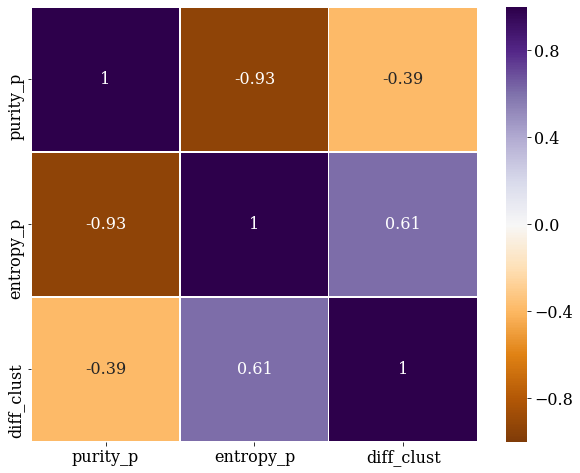

In [57]:
# color map from purple to orange
cmap = cm.get_cmap('PuOr')

plt.rcParams["font.size"] = '16'

# individual heatmap
fig = plt.figure()
fig.set_size_inches(10,8)

# take only the first part of the dataset
correlati = df_cor_pur.corr()
correlati = correlati.round(2)
ax = sns.heatmap(correlati, cmap=cmap, vmin = -1, vmax = 1, annot = True,linewidths=.4)

plt.savefig('../../../thesis/images/corr.png', format='png', bbox_inches='tight')